# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    ShuffleSplit,
    StratifiedShuffleSplit,
)

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# models
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

# 機械学習アルゴリズム
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED
# INDEX_MICROARRAY = config.INDEX_MICROARRAY
INDEX_MICROARRAY = 2
import functions

functions.fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

In [2]:
df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR + "/df_recurrenced.pkl"
)

# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [3]:
def validate_models(
    file_path: str = ".",
    file_name: str = "sample",
):
    try:
        list_train, list_val, _, _ = functions.read_preprocessed_df(
            file_path, file_name
        )
    except:
        return
    X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
    X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

    # accuracyの表示
    print("accuracy: ", (y_train == 1).sum() / y_train.shape[0])
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display(
        functions.compare_bcms(
            X_train,
            y_train,
            X_val,
            y_val,
        )
    )


# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "NPI_CAT",
    # "TUMOR_CAT",
    # "LYMPH_CAT",
]

methods = [
    "variance_threshold",
    # "mrmr"
]

for method in methods:  # 特徴選択手法の適用
    file_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
        "ALL_DATA",
        method,
    )
    print(file_path)
    print("=====" * 10)
    print("method: ", method)
    validate_models(file_path=file_path, file_name="all_data")
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            print("subgroup: ", subgroup)
            file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                method,
            )
            validate_models(file_path=file_path, file_name=subgroup)

./../data/interim/PREPROCESSED/RECURRENCE/CROSS/ALL_DATA/variance_threshold
method:  variance_threshold
accuracy:  0.38449111470113084
使用特徴量： Index(['SYT13', 'ANKRD30BP3', 'CA12', 'HLA-DRB4', 'LCN2', 'SERHL2', 'PVALB',
       'GABRP', 'IGJ', 'SNAR-A3', 'SERPINA3', 'KRT15', 'NAT1', 'GFRA1',
       'SFRP1', 'SLC7A2', 'MMP7', 'SERPINA5', 'SCGB3A1', 'KRT81', 'VTCN1',
       'CYP4Z1', 'GRIA2', 'STC2', 'KRT6B', 'LTF', 'CYP4X1', 'APOD', 'BMPR1B',
       'SCUBE2', 'IGLL1_1', 'TCN1', 'BEX1', 'IGHG1', 'UGT2B11', 'C1orf64',
       'PROM1', 'EEF1A2', 'CALML5', 'UGT2B7', 'HMGCS2', 'ESR1', 'CLIC6',
       'PPP1R1B', 'AGR3', 'SCGB2A1', 'HLA-A', 'VAV3', 'S100A8', 'S100P',
       'TFF3', 'S100A9', 'IGKC', 'CLEC3A', 'CPB1', 'HLA-DRB1', 'ANKRD30A',
       'TFF1', 'PIP', 'SCGB1D2', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (619, 61)


11it [00:01,  5.80it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Naive Bayes,0.621971,0.623188,0.613861,0.606061
Linear SVM,0.726979,0.652174,0.689908,0.600000
Random Forest,0.817447,0.637681,0.782274,0.590164
RBF SVM,0.786753,0.608696,0.759124,0.557377
Decision Tree,0.794830,0.608696,0.742394,0.526316
Quadratic Discriminant Analysis,0.972536,0.623188,0.963441,0.500000
AdaBoost,0.859451,0.637681,0.807095,0.489796
Polynomial SVM,0.998384,0.565217,0.997904,0.482759
Logistic Regression,0.731826,0.608696,0.631111,0.448980


--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
subgroup:  LumB
accuracy:  0.39325842696629215
使用特徴量： Index(['IGLL1_1', 'BMPR1B', 'CLIC6', 'GRIA2', 'VAV3', 'HLA-A', 'BEX1', 'S100P',
       'CLEC3A', 'IGKC', 'TFF1', 'ANKRD30A', 'HLA-DRB1', 'SCGB1D2', 'CPB1',
       'PIP', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (178, 17)


11it [00:00, 30.07it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.769663,0.55,0.748466,0.526316
Quadratic Discriminant Analysis,1.000000,0.60,1.000000,0.428571
Linear SVM,0.679775,0.45,0.645963,0.421053
AdaBoost,0.971910,0.45,0.964029,0.352941
Polynomial SVM,0.977528,0.40,0.972222,0.333333
Logistic Regression,0.707865,0.50,0.573770,0.285714
RBF SVM,0.803371,0.40,0.758621,0.250000
Random Forest,0.792135,0.40,0.748299,0.250000
Naive Bayes,0.679775,0.40,0.577778,0.142857


subgroup:  Her2
accuracy:  0.25555555555555554
使用特徴量： Index(['IGKC', 'PPP1R1B', 'S100A8', 'UGT2B11', 'UGT2B7', 'S100A9', 'PIP',
       'SCGB1D2', 'SCGB2A2'],
      dtype='object')
学習サンプルサイズ： (90, 9)


11it [00:00, 41.83it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.833333,0.727273,0.594595,0.571429
Polynomial SVM,0.866667,0.636364,0.769231,0.500000
RBF SVM,0.822222,0.636364,0.680000,0.500000
Decision Tree,0.777778,0.636364,0.629630,0.333333
Linear SVM,0.677778,0.363636,0.553846,0.222222
AdaBoost,1.000000,0.545455,1.000000,0.000000
Logistic Regression,0.766667,0.727273,0.322581,0.000000
Naive Bayes,0.744444,0.636364,0.410256,0.000000
Quadratic Discriminant Analysis,1.000000,0.636364,1.000000,0.000000


subgroup:  LumA
accuracy:  0.5393258426966292
使用特徴量： Index(['IGKC', 'UGT2B11', 'TFF1', 'GRIA2', 'BEX1', 'UGT2B7', 'TCN1', 'S100P',
       'HMGCS2', 'PIP', 'VAV3', 'CLIC6', 'SCGB2A2', 'HLA-DRB1', 'CPB1',
       'CLEC3A', 'SCGB1D2'],
      dtype='object')
学習サンプルサイズ： (178, 17)


11it [00:00, 30.95it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,1.000000,0.70,1.000000,0.769231
Naive Bayes,0.662921,0.65,0.693878,0.740741
Nearest Neighbors,0.679775,0.65,0.713568,0.740741
RBF SVM,0.758427,0.60,0.777202,0.692308
Random Forest,0.780899,0.60,0.795812,0.692308
Linear SVM,0.691011,0.55,0.715026,0.640000
Logistic Regression,0.668539,0.55,0.703518,0.640000
AdaBoost,0.966292,0.55,0.969388,0.608696
Decision Tree,0.741573,0.50,0.726190,0.545455


subgroup:  claudin-low
pkl file does not exist
subgroup:  Basal
pkl file does not exist
subgroup:  Normal
pkl file does not exist
subgroup:  NC
pkl file does not exist


In [ ]:
def show_val_scores(
    file_path: str = ".",
    file_name: str = "sample",
    clf: callable = RandomForestClassifier(
        min_samples_split=20,
        min_samples_leaf=15,
        random_state=SEED,
        class_weight="balanced",
    ),
    sampling: str = None,
):
    try:
        list_train, list_val, _, _ = functions.read_preprocessed_df(
            file_path, file_name
        )
    except:
        return
    X_train, y_train = list_train[0], list_train[1].map(lambda x: int(x))
    X_val, y_val = list_val[0], list_val[1].map(lambda x: int(x))

    # accuracyの表示
    print("-----" * 10)
    print("accuracy: ", (y_train == 1).sum() / y_train.shape[0])
    print("学習サンプルサイズ：", X_train.shape)
    print("予測モデル：", clf.__class__.__name__)
    if sampling == "sm":
        sm = SMOTE(random_state=SEED)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    functions.show_scores(y_val, y_pred)
    functions.plot_confusion_matrix(y_val, y_pred)

method:  variance_threshold
--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
..................................................
subgroup:  LumB
--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： LogisticRegression


accuracy     0.500000
precision    0.333333
recall       0.250000
f1 score     0.285714
dtype: float64

--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： KNeighborsClassifier


accuracy     0.45
precision    0.00
recall       0.00
f1 score     0.00
dtype: float64

--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： SVC


accuracy     0.40
precision    0.25
recall       0.25
f1 score     0.25
dtype: float64

--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： RandomForestClassifier


accuracy     0.40
precision    0.25
recall       0.25
f1 score     0.25
dtype: float64

--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： LGBMClassifier


accuracy     0.550000
precision    0.428571
recall       0.375000
f1 score     0.400000
dtype: float64

..................................................
subgroup:  Her2
--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： LogisticRegression


accuracy     0.727273
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： KNeighborsClassifier


accuracy     0.727273
precision    0.500000
recall       0.666667
f1 score     0.571429
dtype: float64

--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： SVC


accuracy     0.636364
precision    0.400000
recall       0.666667
f1 score     0.500000
dtype: float64

--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： RandomForestClassifier


accuracy     0.545455
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： LGBMClassifier


accuracy     0.818182
precision    0.666667
recall       0.666667
f1 score     0.666667
dtype: float64

..................................................
subgroup:  LumA
--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： LogisticRegression


accuracy     0.550000
precision    0.571429
recall       0.727273
f1 score     0.640000
dtype: float64

--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： KNeighborsClassifier


accuracy     0.650000
precision    0.625000
recall       0.909091
f1 score     0.740741
dtype: float64

--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： SVC


accuracy     0.600000
precision    0.600000
recall       0.818182
f1 score     0.692308
dtype: float64

--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： RandomForestClassifier


accuracy     0.600000
precision    0.600000
recall       0.818182
f1 score     0.692308
dtype: float64

--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： LGBMClassifier


accuracy     0.550000
precision    0.600000
recall       0.545455
f1 score     0.571429
dtype: float64

..................................................
subgroup:  claudin-low
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
..................................................
subgroup:  Basal
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
..................................................
subgroup:  Normal
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
..................................................
subgroup:  NC
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist


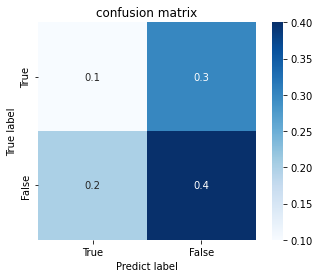

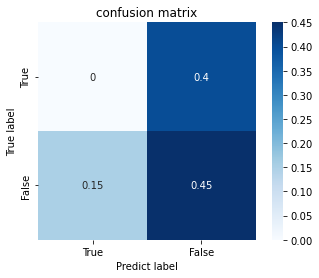

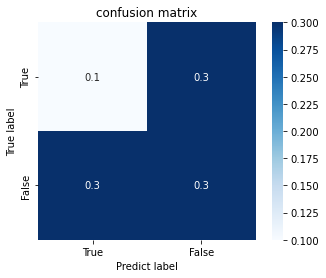

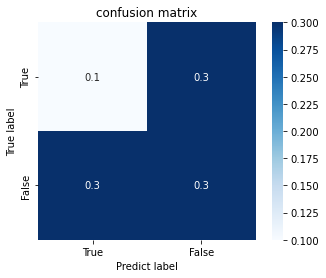

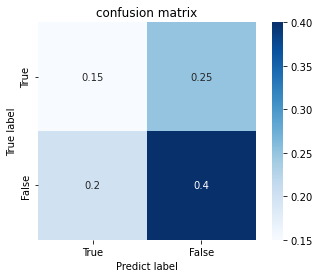

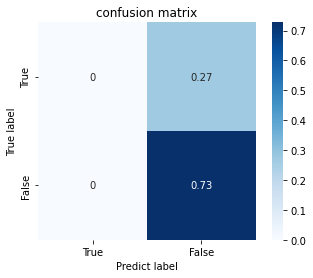

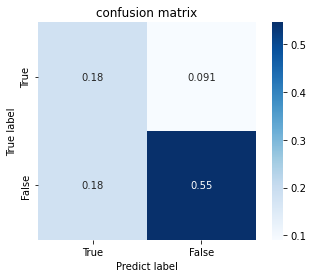

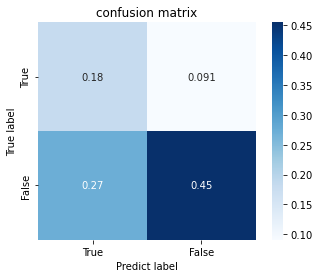

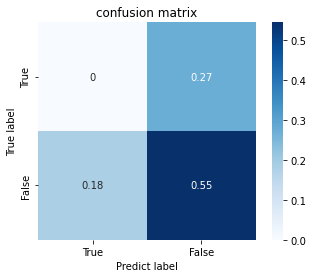

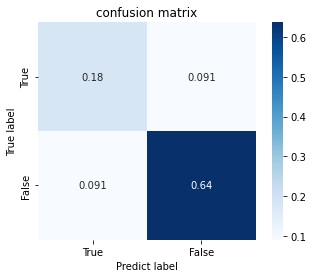

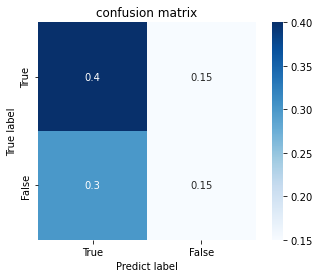

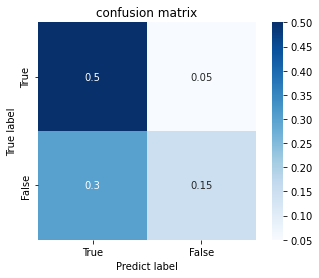

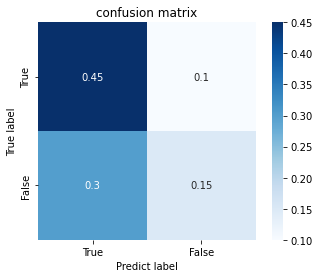

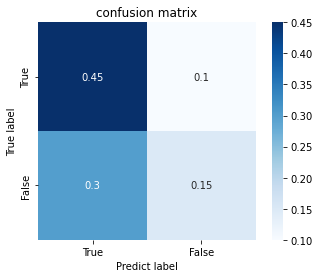

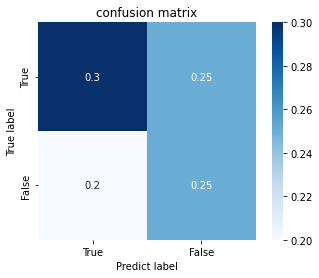

In [7]:
# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    #    "NPI_CAT",
    #    "TUMOR_CAT",
    #    "LYMPH_CAT",
]

methods = [
    "variance_threshold",
    #       "mrmr"
]


for method in methods:  # 特徴選択手法の適用
    print("=====" * 10)
    print("method: ", method)
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            print("....." * 10)
            print("subgroup: ", subgroup)
            file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                method,
            )
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=LogisticRegression(random_state=SEED),
            )
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=KNeighborsClassifier(),
            )
            params = {
                "class_weight": "balanced",
                "random_state": SEED,
            }
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=SVC(**params),
            )
            params = {
                "min_samples_split": 20,
                "min_samples_leaf": 15,
                "random_state": SEED,
                "class_weight": "balanced",
            }
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=RandomForestClassifier(**params),
            )
            params = {
                "max_bin": 100,
                "num_leaves": 30,
                "n_estimators": 800,
                "class_weight": "balanced",
                "random_state": SEED,
            }
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=LGBMClassifier(**params),
            )

method:  variance_threshold
--------------------------------------------------
subgroup column:  CLAUDIN_SUBTYPE
..................................................
subgroup:  LumB
--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： LogisticRegression


accuracy     0.500000
precision    0.400000
recall       0.500000
f1 score     0.444444
dtype: float64

--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： KNeighborsClassifier


accuracy     0.450000
precision    0.363636
recall       0.500000
f1 score     0.421053
dtype: float64

--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： SVC


accuracy     0.550000
precision    0.400000
recall       0.250000
f1 score     0.307692
dtype: float64

--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： RandomForestClassifier


accuracy     0.500
precision    0.375
recall       0.375
f1 score     0.375
dtype: float64

--------------------------------------------------
accuracy:  0.39325842696629215
学習サンプルサイズ： (178, 17)
予測モデル： LGBMClassifier


accuracy     0.550000
precision    0.428571
recall       0.375000
f1 score     0.400000
dtype: float64

..................................................
subgroup:  Her2
--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： LogisticRegression


accuracy     0.636364
precision    0.400000
recall       0.666667
f1 score     0.500000
dtype: float64

--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： KNeighborsClassifier


accuracy     0.545455
precision    0.333333
recall       0.666667
f1 score     0.444444
dtype: float64

--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： SVC


accuracy     0.636364
precision    0.400000
recall       0.666667
f1 score     0.500000
dtype: float64

--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： RandomForestClassifier


accuracy     0.727273
precision    0.500000
recall       0.666667
f1 score     0.571429
dtype: float64

--------------------------------------------------
accuracy:  0.25555555555555554
学習サンプルサイズ： (90, 9)
予測モデル： LGBMClassifier


accuracy     0.727273
precision    0.500000
recall       0.666667
f1 score     0.571429
dtype: float64

..................................................
subgroup:  LumA
--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： LogisticRegression


accuracy     0.500000
precision    0.538462
recall       0.636364
f1 score     0.583333
dtype: float64

--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： KNeighborsClassifier


accuracy     0.600000
precision    0.600000
recall       0.818182
f1 score     0.692308
dtype: float64

--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： SVC


accuracy     0.600000
precision    0.600000
recall       0.818182
f1 score     0.692308
dtype: float64

--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： RandomForestClassifier


accuracy     0.600000
precision    0.615385
recall       0.727273
f1 score     0.666667
dtype: float64

--------------------------------------------------
accuracy:  0.5393258426966292
学習サンプルサイズ： (178, 17)
予測モデル： LGBMClassifier


accuracy     0.500000
precision    0.545455
recall       0.545455
f1 score     0.545455
dtype: float64

..................................................
subgroup:  claudin-low
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
..................................................
subgroup:  Basal
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
..................................................
subgroup:  Normal
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
..................................................
subgroup:  NC
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist
pkl file does not exist


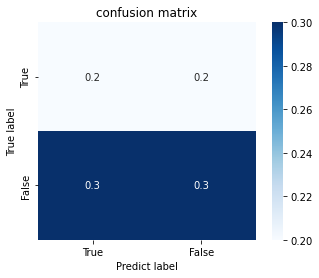

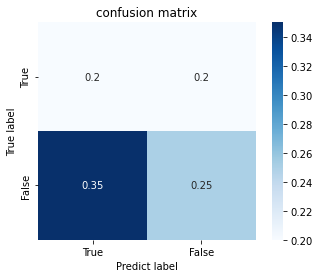

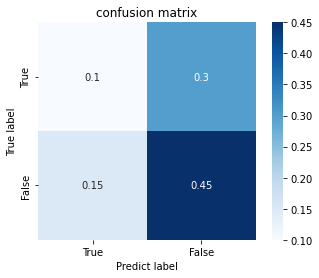

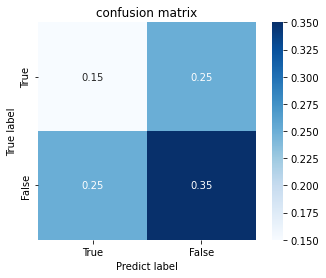

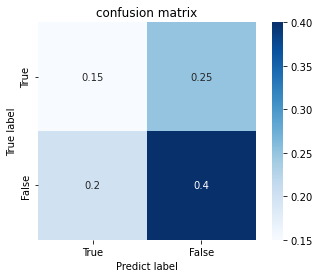

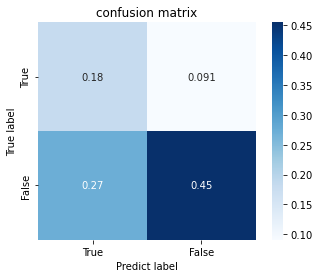

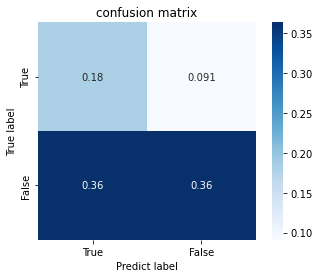

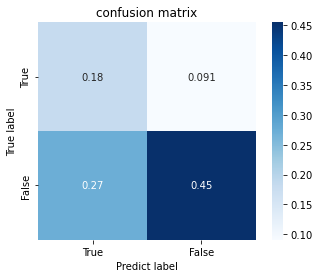

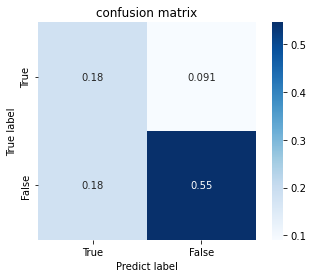

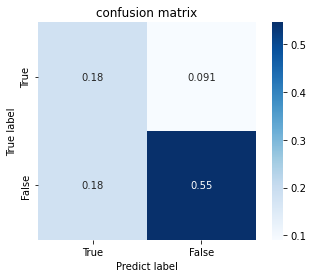

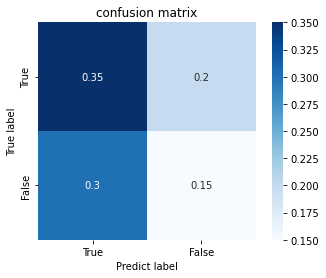

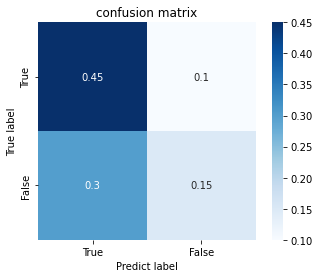

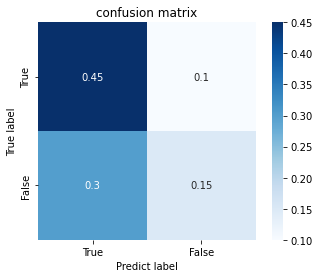

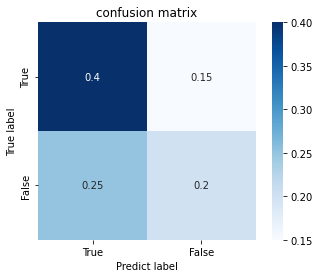

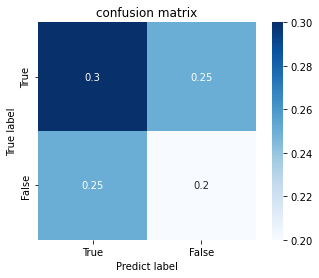

In [6]:
# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    #    "NPI_CAT",
    #    "TUMOR_CAT",
    #    "LYMPH_CAT",
]

methods = [
    "variance_threshold",
    #       "mrmr"
]


for method in methods:  # 特徴選択手法の適用
    print("=====" * 10)
    print("method: ", method)
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        print("-----" * 10)
        print("subgroup column: ", subgroup_column)
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            print("....." * 10)
            print("subgroup: ", subgroup)
            file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_CROSS_DIR,
                subgroup_column,
                method,
            )
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=LogisticRegression(random_state=SEED),
                sampling="sm",
            )
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=KNeighborsClassifier(),
                sampling="sm",
            )
            params = {
                "class_weight": "balanced",
                "random_state": SEED,
            }
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=SVC(**params),
                sampling="sm",
            )
            params = {
                "min_samples_split": 20,
                "min_samples_leaf": 15,
                "random_state": SEED,
                "class_weight": "balanced",
            }
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=RandomForestClassifier(**params),
                sampling="sm",
            )
            params = {
                "max_bin": 100,
                "num_leaves": 30,
                "n_estimators": 800,
                "class_weight": "balanced",
                "random_state": SEED,
            }
            show_val_scores(
                file_path=file_path,
                file_name=subgroup,
                clf=LGBMClassifier(**params),
                sampling="sm",
            )

## xgboost

In [5]:
import xgboost as xgb

X_train = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"]["X15"]
y_train = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"]["y15"]
X_val = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"]["X15"]
y_val = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"]["y15"]

xgb_train = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns)
xgb_val = xgb.DMatrix(X_val, label=y_val, feature_names=X_val.columns)


param = {
    # 二値分類問題
    "objective": "binary:logistic",
}
clf = xgb.train(param, xgb_train)
y_pred_proba = clf.predict(xgb_val)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)

[05:23:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.6494845360824743, 0.6730769230769231)